# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv('./autos.csv')

In [3]:
df = df.rename(columns=str.lower)

In [4]:
df

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  notrepaired        283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.isna().any()

datecrawled          False
price                False
vehicletype           True
registrationyear     False
gearbox               True
power                False
model                 True
kilometer            False
registrationmonth    False
fueltype              True
brand                False
notrepaired           True
datecreated          False
numberofpictures     False
postalcode           False
lastseen             False
dtype: bool

In [7]:
df['price'].min()

0

Итак как мы можем заметить цена может быть нулевой, что вряд ли является правдой, поэтому давайте сделаем некую отсечку например в 100 евро которую примем за минимальную стоимость. Хотя как я посмотрел средняя масса машина варьируется от 1-1.5 тонны, а стоимость в европе 1кг стали(по большей части из которого состтоит машина) составляет 7евро. Что означает что даже 100 евро очень мало, но так как мы иначе потеряем слишком много данных при отсечке в 700 евро например, что является приблизительной стоимость если сдать машину на металлолом, поэтому я не уверен что отсечка в 100 евро является верной но как видно на боксплоте такие данные не выбиваются от нормальных значений

<AxesSubplot:>

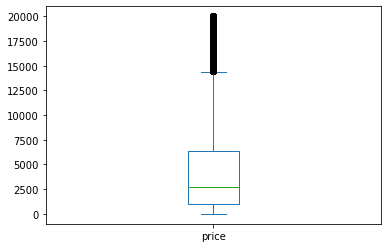

In [8]:
df['price'].plot.box()

In [9]:
df['price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

In [10]:
df.drop(df[df['price'] < 100].index, inplace=True)

Видно что данные о регистрации машины неправильные попытаемся проанализировать данные чтобы решитть эту проблему

In [11]:
df['registrationyear'].min(), df['registrationyear'].max()

(1000, 9999)

In [12]:
df

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [13]:
df['lastseen']= pd.to_datetime(df['lastseen'], format='%Y-%m-%d %H:%M:%S')

In [14]:
pd.DatetimeIndex(df['lastseen']).year.max()

2016

Видно что дата последнего посещения это 2016 год поэтому сделаем отсечку по максимуму по этому значению,  минимума по очень старым значений годов например 1930 год когда были уже машины и теоретически такие могли быть выложены как что то очень раритетное

In [15]:
df['datecrawled']= pd.to_datetime(df['datecrawled'], format='%Y-%m-%d %H:%M:%S')

In [16]:
pd.DatetimeIndex(df['datecrawled']).year.max()

2016

In [17]:
df[df['registrationyear'] > 2016].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13687 entries, 22 to 354289
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   datecrawled        13687 non-null  datetime64[ns]
 1   price              13687 non-null  int64         
 2   vehicletype        19 non-null     object        
 3   registrationyear   13687 non-null  int64         
 4   gearbox            12009 non-null  object        
 5   power              13687 non-null  int64         
 6   model              11844 non-null  object        
 7   kilometer          13687 non-null  int64         
 8   registrationmonth  13687 non-null  int64         
 9   fueltype           8484 non-null   object        
 10  brand              13687 non-null  object        
 11  notrepaired        7795 non-null   object        
 12  datecreated        13687 non-null  object        
 13  numberofpictures   13687 non-null  int64         
 14  post

Можно заметить что если делать отсечку после 2016 года то кол-во пропущенных значений в таких колонках как `vehicletype` `fueltype`, `notrepaired` достаточно велико, что может нас склонять к тому что данные заполненые после 2016 года являются скорее неким выбросом нежели реальными данными, поэтому я все таки решил оставить этот год как значение по которому мы производим отсечку

In [18]:
df[df['registrationyear'] < 1930]['registrationyear'].values

array([1910, 1925, 1910, 1910, 1000, 1500, 1929, 1910, 1800, 1910, 1234,
       1910, 1000, 1000, 1400, 1910, 1910, 1910, 1000, 1255, 1000, 1910,
       1910, 1000, 1910, 1910, 1000, 1000, 1234, 1000, 1000, 1910, 1923,
       1500, 1001, 1234, 1000, 1929, 1910, 1000, 1929, 1800, 1000, 1234,
       1910, 1000, 1928, 1000, 1000, 1910, 1910, 1910, 1910, 1000, 1600,
       1111, 1800, 1039, 1910, 1910, 1929, 1928, 1929, 1910, 1910, 1000,
       1000, 1300, 1000, 1910, 1910, 1910, 1000, 1910, 1910, 1500, 1910,
       1602, 1927, 1910, 1300, 1910, 1923, 1000, 1910, 1929, 1600, 1800,
       1910])

In [19]:
df[df['registrationyear'] < 1930].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89 entries, 15 to 353961
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   datecrawled        89 non-null     datetime64[ns]
 1   price              89 non-null     int64         
 2   vehicletype        21 non-null     object        
 3   registrationyear   89 non-null     int64         
 4   gearbox            28 non-null     object        
 5   power              89 non-null     int64         
 6   model              47 non-null     object        
 7   kilometer          89 non-null     int64         
 8   registrationmonth  89 non-null     int64         
 9   fueltype           31 non-null     object        
 10  brand              89 non-null     object        
 11  notrepaired        22 non-null     object        
 12  datecreated        89 non-null     object        
 13  numberofpictures   89 non-null     int64         
 14  postalc

In [20]:
df.drop(index=df[(df['registrationyear'] > 2016) | (df['registrationyear'] < 1930)].index, inplace=True)

In [21]:
df.reset_index(inplace=True, drop=True)

In [22]:
df

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327274,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23
327275,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
327276,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
327277,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


Итак со странностями в данных 'справились' теперь посморим как заполнить пропущенные значения в колонках. Будем заполнять пропущенные значения самыми повторяющимися значения из сводных таблиц или таблиц полученых методом `.groupby()`. Начнём с колонки `model`

### `model`-col

Итак чтобы заполнить колонку `model` я попытался разбить все данные с помощью столбцов `brand, registrationyear, power, price` при помощи построения свободной таблицы, где значения внутри этой таблицы заполняются самым часто встречающимся значением</div>

In [23]:
p_1 = pd.pivot_table(df, values='model', index=['brand','registrationyear', 'power'],columns='price', aggfunc=pd.Series.mode)

Затем я создал функцию суть которой состоит в том чтобы разрешать конфликтные моменты если например у меня в выдаче получилось, вместо одного значения модели (напр. c-class), два и более значений (напр. [c-class, e-class,b-class]) или вовсе значение отсутсвует. Данная функция будет выбирать значение с индексом 0 и создавать в конечном итоге список из таких моделей. По сути эта функция аналогична функции `transform()` где данные заполняются в зависимости от выбранной функции для 'трансформирования данных', вообщем надеюсь так понятно)</div>

In [24]:
def model_determine(list):
    model_list = []
    num = 0
    for i in list:
        if type(p_1.loc[i[0], i[2], i[3]][i[1]]) == np.ndarray:
            num += 1
            try:
                model_list.append(p_1.loc[i[0], i[2], i[3]][i[1]][0])
            except:
                model_list.append('')
        else:
            model_list.append(p_1.loc[i[0], i[2], i[3]][i[1]])
    print(num)
    return model_list    

При вызове строки снизу показывается число как раз таких конфликтных моментов и создается обьект типа list которым мы будем запонять пропуски в колонке `model`. 

In [25]:
a = model_determine(df[['brand','price','registrationyear', 'power']].values)

34465


In [26]:
df['model'] = df['model'].fillna(pd.Series(a))

In [27]:
df.drop(index = df[df['model'] == ''].index, inplace=True)

In [28]:
df.reset_index(drop=True, inplace=True)

In [29]:
df.isna().any()

datecrawled          False
price                False
vehicletype           True
registrationyear     False
gearbox               True
power                False
model                False
kilometer            False
registrationmonth    False
fueltype              True
brand                False
notrepaired           True
datecreated          False
numberofpictures     False
postalcode           False
lastseen             False
dtype: bool

Здесь чтобы заполнить колонку `vehicletype` я решил что можно сгрупоировать значения по модели машины ведь скорее всего модели в основном определяют тип кузова(как мне по крайней мере всегда казалось) и выбирать также самое частое значение. Сама же функцию выполняет полностью аналогичную роль с функцией `model_determine`

### `vehicletype`-col

In [30]:
g_1 = df.groupby('model')['vehicletype'].agg(pd.Series.mode)

In [31]:
def vehicletype_determine(list):
    vehicle_type = []
    num = 0 
    for i in list:
        if type(g_1[i]) == np.ndarray:
            num += 1 
            try:
                vehicle_type.append(g_1.loc[i][0])
            except:
                vehicle_type.append('')
        else:
            vehicle_type.append(g_1.loc[i])
    print(num)        
    return vehicle_type

In [32]:
a  = pd.Series(vehicletype_determine(df['model'].values))

10


In [33]:
df['vehicletype'].fillna(a,inplace=True)

In [34]:
df.drop(index = df[df['vehicletype'] == ''].index, inplace=True)

In [35]:
df.reset_index(drop=True, inplace=True)

In [36]:
df.isna().any()

datecrawled          False
price                False
vehicletype          False
registrationyear     False
gearbox               True
power                False
model                False
kilometer            False
registrationmonth    False
fueltype              True
brand                False
notrepaired           True
datecreated          False
numberofpictures     False
postalcode           False
lastseen             False
dtype: bool

### `gearbox`- col

In [37]:
p_2 = df.pivot_table(values='gearbox', index='model', columns='registrationyear', aggfunc=pd.Series.mode)

In [38]:
def gearbox_determine(list):
    model_list = []
    num = 0
    for i in list:
        if type(p_2.loc[i[0]][i[1]]) == np.ndarray:
            num +=1
            try:
                model_list.append(p_2.loc[i[0]][i[1]][0])
            except:
                model_list.append('')
        else:
            model_list.append(p_2.loc[i[0]][i[1]])
    print(num)            
    return model_list    

In [39]:
a = gearbox_determine(df[['model','registrationyear']].values)

591


In [40]:
df['gearbox'] = df['gearbox'].fillna(pd.Series(a))

In [41]:
df.drop(index = df[df['gearbox'] == ''].index, inplace=True)

In [42]:
df.reset_index(drop=True, inplace=True)

In [43]:
df.isna().any()

datecrawled          False
price                False
vehicletype          False
registrationyear     False
gearbox              False
power                False
model                False
kilometer            False
registrationmonth    False
fueltype              True
brand                False
notrepaired           True
datecreated          False
numberofpictures     False
postalcode           False
lastseen             False
dtype: bool

### `notrepaired`-col

In [44]:
p_3 = df.pivot_table(values='notrepaired', index='kilometer', columns='registrationyear', aggfunc=pd.Series.mode)

In [45]:
def notrepaired_determine(list):
    new_list = []
    num = 0 
    for i in list:
        if type(p_3.loc[i[0]][i[1]]) == np.ndarray:
            num += 1 
            try:
                new_list.append(p_3.loc[i[0]][i[1]][0])
            except:
                new_list.append('')
        else:
            new_list.append(p_3.loc[i[0]][i[1]])
    print(num)            
    return new_list    

In [46]:
a = notrepaired_determine(df[['kilometer','registrationyear']].values)

114


In [47]:
df['notrepaired'] = df['notrepaired'].fillna(pd.Series(a))

In [48]:
df.drop(index = df[df['notrepaired'] == ''].index, inplace=True)

In [49]:
df.reset_index(drop=True, inplace=True)

In [50]:
df.isna().any()

datecrawled          False
price                False
vehicletype          False
registrationyear     False
gearbox              False
power                False
model                False
kilometer            False
registrationmonth    False
fueltype              True
brand                False
notrepaired          False
datecreated          False
numberofpictures     False
postalcode           False
lastseen             False
dtype: bool

### `fueltype`-col

In [51]:
p_4 = pd.pivot_table(df, values='fueltype', index=['model', 'power'], columns='registrationyear', aggfunc=pd.Series.mode)

In [52]:
def fueltype_determine(list):
    new_list = []
    num = 0
    for i in list:
        if type(p_4.loc[i[0], i[2]][i[1]]) == np.ndarray:
            num +=1
            try:
                new_list.append(p_4.loc[i[0], i[2]][i[1]][0])
            except:
                new_list.append('')
        else:
            new_list.append(p_4.loc[i[0], i[2]][i[1]])
    print(num)            
    return new_list    

In [53]:
a = fueltype_determine(df[['model','registrationyear', 'power']].values)

4389


In [54]:
df['fueltype'] = df['fueltype'].fillna(pd.Series(a))

In [55]:
df.drop(index = df[df['fueltype'] == ''].index, inplace=True)

In [56]:
df.reset_index(drop=True, inplace=True)

In [57]:
df.isna().any()

datecrawled          False
price                False
vehicletype          False
registrationyear     False
gearbox              False
power                False
model                False
kilometer            False
registrationmonth    False
fueltype             False
brand                False
notrepaired          False
datecreated          False
numberofpictures     False
postalcode           False
lastseen             False
dtype: bool

## Обучение моделей

Итак сначала уберем из наших таблиц данные который точно не должны повлиять на значение цены(которая является нашим таргетом)

In [58]:
needless_col = [x.lower() for x in ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen']]
df.drop(columns=needless_col, inplace=True)

Теперь применим технику порядкового кодирования, чтобы перевести категориальные данные в числовые(По правде сказать изначально я сделал этот перевод потому что не мог обучить с категориальными данными модель LightGBM, но после того как перевел заметил что значения на Catboost значительно улучшились, так например RMSE был 1500 на catboost, с категориальными данными, а после стал 300, поэтому решил полностью ко всем моделям это применить, но не совсем понимаю почему результат получается лучше, ведь обе модели рассчитаны на работу с категориальными данными)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316303 entries, 0 to 316302
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              316303 non-null  int64 
 1   vehicletype        316303 non-null  object
 2   registrationyear   316303 non-null  int64 
 3   gearbox            316303 non-null  object
 4   power              316303 non-null  int64 
 5   model              316303 non-null  object
 6   kilometer          316303 non-null  int64 
 7   registrationmonth  316303 non-null  int64 
 8   fueltype           316303 non-null  object
 9   brand              316303 non-null  object
 10  notrepaired        316303 non-null  object
 11  postalcode         316303 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 29.0+ MB


In [60]:
col = list(df.loc[:, df.dtypes == 'object'].columns)

In [61]:
enc = OrdinalEncoder()
enc.fit(df[col])
df[col] = enc.transform(df[col])

In [62]:
df_train, df_other = train_test_split(df, test_size=0.4, random_state=12345)

In [63]:
df_valid, df_test = train_test_split(df_other, test_size=0.5, random_state=12345)

In [64]:
features_train = df_train.drop(columns='price')
target_train = df_train.price

In [65]:
features_valid = df_valid.drop(columns='price')
target_valid = df_valid.price

In [66]:
features_test = df_test.drop(columns='price')
target_test = df_test.price

Теперь обучим модели на полученныз данных. Возьмем 3 модели: Catboost, LightGBM, LinearRegression. Начнём с первой

### Catboost

In [67]:
model = CatBoostRegressor(iterations=2000, learning_rate=0.05, depth=10, loss_function = 'MAE', eval_metric = 'RMSE')

In [68]:
start_time = time.time()
model.fit(features_train, target_train, use_best_model=True, silent=True, eval_set=(features_valid, target_valid))
catboost_exec_time = time.time() - start_time

In [69]:
model.best_score_

{'learn': {'MAE': 805.151549138584, 'RMSE': 1365.38860508379},
 'validation': {'MAE': 933.0495554442903, 'RMSE': 1558.2092670847323}}

In [70]:
mse_catboost = mean_squared_error(target_test, model.predict(features_test))
rmse_catboost = mse_catboost ** 0.5

In [71]:
rmse_catboost

1539.4826193230224

### LGBMmse_catboost

In [72]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    "num_iterations": 1000,
    "n_estimators": 10000
}


In [73]:
lgb_train = lgb.Dataset(features_train, target_train)
lgb_eval = lgb.Dataset(features_test, target_test, reference=lgb_train)

In [74]:
start_time = time.time()
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)
lgbm_exec_time = time.time() - start_time

/Users/ramen/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ramen/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/ramen/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's l2: 1.91401e+07	valid_0's l1: 3428.88
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 1.77994e+07	valid_0's l1: 3299.06
[3]	valid_0's l2: 1.6587e+07	valid_0's l1: 3177.25
[4]	valid_0's l2: 1.54847e+07	valid_0's l1: 3061.52
[5]	valid_0's l2: 1.44927e+07	valid_0's l1: 2953.5
[6]	valid_0's l2: 1.35871e+07	valid_0's l1: 2852.67
[7]	valid_0's l2: 1.27622e+07	valid_0's l1: 2757.41
[8]	valid_0's l2: 1.20104e+07	valid_0's l1: 2667.6
[9]	valid_0's l2: 1.13311e+07	valid_0's l1: 2583.24
[10]	valid_0's l2: 1.07102e+07	valid_0's l1: 2504.41
[11]	valid_0's l2: 1.01779e+07	valid_0's l1: 2432.51
[12]	valid_0's l2: 9.65759e+06	valid_0's l1: 2362.77
[13]	valid_0's l2: 9.18579e+06	valid_0's l1: 2296.68
[14]	valid_0's l2: 8.74618e+06	val

[187]	valid_0's l2: 2.74452e+06	valid_0's l1: 1058.84
[188]	valid_0's l2: 2.74203e+06	valid_0's l1: 1058.37
[189]	valid_0's l2: 2.74056e+06	valid_0's l1: 1058.08
[190]	valid_0's l2: 2.73814e+06	valid_0's l1: 1057.57
[191]	valid_0's l2: 2.73709e+06	valid_0's l1: 1057.36
[192]	valid_0's l2: 2.73535e+06	valid_0's l1: 1057.03
[193]	valid_0's l2: 2.73429e+06	valid_0's l1: 1056.78
[194]	valid_0's l2: 2.73262e+06	valid_0's l1: 1056.53
[195]	valid_0's l2: 2.73202e+06	valid_0's l1: 1056.38
[196]	valid_0's l2: 2.73112e+06	valid_0's l1: 1056.15
[197]	valid_0's l2: 2.72945e+06	valid_0's l1: 1055.72
[198]	valid_0's l2: 2.72702e+06	valid_0's l1: 1055.3
[199]	valid_0's l2: 2.72622e+06	valid_0's l1: 1055.09
[200]	valid_0's l2: 2.72482e+06	valid_0's l1: 1054.69
[201]	valid_0's l2: 2.72285e+06	valid_0's l1: 1054.31
[202]	valid_0's l2: 2.72135e+06	valid_0's l1: 1054.01
[203]	valid_0's l2: 2.71993e+06	valid_0's l1: 1053.72
[204]	valid_0's l2: 2.71815e+06	valid_0's l1: 1053.37
[205]	valid_0's l2: 2.71636e+

[342]	valid_0's l2: 2.57202e+06	valid_0's l1: 1021.64
[343]	valid_0's l2: 2.57083e+06	valid_0's l1: 1021.38
[344]	valid_0's l2: 2.56974e+06	valid_0's l1: 1021.09
[345]	valid_0's l2: 2.56886e+06	valid_0's l1: 1020.77
[346]	valid_0's l2: 2.56728e+06	valid_0's l1: 1020.39
[347]	valid_0's l2: 2.56551e+06	valid_0's l1: 1020.07
[348]	valid_0's l2: 2.56419e+06	valid_0's l1: 1019.79
[349]	valid_0's l2: 2.56387e+06	valid_0's l1: 1019.67
[350]	valid_0's l2: 2.56312e+06	valid_0's l1: 1019.57
[351]	valid_0's l2: 2.56142e+06	valid_0's l1: 1019.21
[352]	valid_0's l2: 2.56062e+06	valid_0's l1: 1019.04
[353]	valid_0's l2: 2.5594e+06	valid_0's l1: 1018.72
[354]	valid_0's l2: 2.55872e+06	valid_0's l1: 1018.51
[355]	valid_0's l2: 2.55817e+06	valid_0's l1: 1018.42
[356]	valid_0's l2: 2.55786e+06	valid_0's l1: 1018.38
[357]	valid_0's l2: 2.55658e+06	valid_0's l1: 1018.03
[358]	valid_0's l2: 2.55622e+06	valid_0's l1: 1017.96
[359]	valid_0's l2: 2.55458e+06	valid_0's l1: 1017.62
[360]	valid_0's l2: 2.55415e+

[506]	valid_0's l2: 2.47658e+06	valid_0's l1: 999.023
[507]	valid_0's l2: 2.47531e+06	valid_0's l1: 998.799
[508]	valid_0's l2: 2.47519e+06	valid_0's l1: 998.768
[509]	valid_0's l2: 2.47478e+06	valid_0's l1: 998.68
[510]	valid_0's l2: 2.4745e+06	valid_0's l1: 998.648
[511]	valid_0's l2: 2.47417e+06	valid_0's l1: 998.582
[512]	valid_0's l2: 2.47398e+06	valid_0's l1: 998.531
[513]	valid_0's l2: 2.47328e+06	valid_0's l1: 998.409
[514]	valid_0's l2: 2.47318e+06	valid_0's l1: 998.355
[515]	valid_0's l2: 2.47265e+06	valid_0's l1: 998.258
[516]	valid_0's l2: 2.47239e+06	valid_0's l1: 998.183
[517]	valid_0's l2: 2.47156e+06	valid_0's l1: 998.018
[518]	valid_0's l2: 2.47122e+06	valid_0's l1: 997.942
[519]	valid_0's l2: 2.47066e+06	valid_0's l1: 997.773
[520]	valid_0's l2: 2.47042e+06	valid_0's l1: 997.697
[521]	valid_0's l2: 2.4699e+06	valid_0's l1: 997.58
[522]	valid_0's l2: 2.46959e+06	valid_0's l1: 997.534
[523]	valid_0's l2: 2.46934e+06	valid_0's l1: 997.482
[524]	valid_0's l2: 2.46915e+06	

[678]	valid_0's l2: 2.41639e+06	valid_0's l1: 985.877
[679]	valid_0's l2: 2.41594e+06	valid_0's l1: 985.776
[680]	valid_0's l2: 2.41534e+06	valid_0's l1: 985.582
[681]	valid_0's l2: 2.41509e+06	valid_0's l1: 985.523
[682]	valid_0's l2: 2.41483e+06	valid_0's l1: 985.447
[683]	valid_0's l2: 2.41467e+06	valid_0's l1: 985.362
[684]	valid_0's l2: 2.41445e+06	valid_0's l1: 985.304
[685]	valid_0's l2: 2.41403e+06	valid_0's l1: 985.196
[686]	valid_0's l2: 2.41355e+06	valid_0's l1: 985.085
[687]	valid_0's l2: 2.41344e+06	valid_0's l1: 985.07
[688]	valid_0's l2: 2.41327e+06	valid_0's l1: 985.027
[689]	valid_0's l2: 2.41318e+06	valid_0's l1: 984.997
[690]	valid_0's l2: 2.41287e+06	valid_0's l1: 984.929
[691]	valid_0's l2: 2.41261e+06	valid_0's l1: 984.882
[692]	valid_0's l2: 2.41242e+06	valid_0's l1: 984.853
[693]	valid_0's l2: 2.41203e+06	valid_0's l1: 984.77
[694]	valid_0's l2: 2.41177e+06	valid_0's l1: 984.728
[695]	valid_0's l2: 2.41101e+06	valid_0's l1: 984.661
[696]	valid_0's l2: 2.41055e+0

[831]	valid_0's l2: 2.37866e+06	valid_0's l1: 976.984
[832]	valid_0's l2: 2.37852e+06	valid_0's l1: 976.951
[833]	valid_0's l2: 2.37807e+06	valid_0's l1: 976.849
[834]	valid_0's l2: 2.37768e+06	valid_0's l1: 976.779
[835]	valid_0's l2: 2.37723e+06	valid_0's l1: 976.694
[836]	valid_0's l2: 2.37716e+06	valid_0's l1: 976.681
[837]	valid_0's l2: 2.37715e+06	valid_0's l1: 976.694
[838]	valid_0's l2: 2.37678e+06	valid_0's l1: 976.631
[839]	valid_0's l2: 2.37668e+06	valid_0's l1: 976.621
[840]	valid_0's l2: 2.37654e+06	valid_0's l1: 976.607
[841]	valid_0's l2: 2.3766e+06	valid_0's l1: 976.59
[842]	valid_0's l2: 2.3765e+06	valid_0's l1: 976.587
[843]	valid_0's l2: 2.37646e+06	valid_0's l1: 976.584
[844]	valid_0's l2: 2.37625e+06	valid_0's l1: 976.521
[845]	valid_0's l2: 2.37597e+06	valid_0's l1: 976.429
[846]	valid_0's l2: 2.37586e+06	valid_0's l1: 976.375
[847]	valid_0's l2: 2.37589e+06	valid_0's l1: 976.338
[848]	valid_0's l2: 2.37592e+06	valid_0's l1: 976.323
[849]	valid_0's l2: 2.37602e+06

In [75]:
y_pred = gbm.predict(features_test, num_iteration=gbm.best_iteration)

In [76]:
mse_lgbm = mean_squared_error(target_test, y_pred)
rmse_lgbm = mse_lgbm ** 0.5

In [77]:
rmse_lgbm

1541.381310404437

### LinearRegression

In [78]:
model = LinearRegression(fit_intercept=True, normalize=True)

In [79]:
start_time = time.time()
model.fit(features_train, target_train)
linear_exec_time = time.time() - start_time

/Users/ramen/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


In [80]:
model.predict(features_test)

array([ 826.40352882, 4713.45691708, 8169.70238789, ..., 4238.13540077,
       6177.57819743, 5697.5470626 ])

In [81]:
mse_linear = mean_squared_error(target_test, model.predict(features_test))
rmse_linear = mse_linear ** 0.5

In [82]:
rmse_linear

3329.264975708837

## Анализ моделей

In [83]:
RMSE = [rmse_catboost, rmse_lgbm, rmse_linear]

In [84]:
fit_time = [catboost_exec_time, lgbm_exec_time, linear_exec_time]

In [85]:
pd.DataFrame([RMSE, fit_time], index = ['RMSE', 'Fit time'], columns=['Catboost', 'LightGBM', 'LinearRegression'])

,Catboost,LightGBM,LinearRegression
RMSE,1539.482619,1541.38131,3329.264976
Fit time,41.028169,3.99592,0.087102


Видно что лучше всех справился Catboost, но при этом он дольше всех работал, хуже всех себя показала линейная регрессия, но она оказалась самой быстрой. При этом самым оптимальным выбором между качество и временем является LightGBM